In [22]:
# Obtiene los datos de precipitación par la Cuenca del Valle
# de Méxco a partir de CHIRPS y los promedia espacialmente.

import pandas as pd
import numpy as np
import matplotlib

import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib import ticker

# Permite ajustar los valores de todas las gráficas
#params = {"ytick.color" : "w",
#          "xtick.color" : "w",
#          "axes.labelcolor" : "w",
#          "axes.edgecolor" : "w",
#          "text.color": "w"}
#plt.rcParams.update(params)

In [23]:
# Datos.
# viento 925 hPa.

path_ds = "../data/ERA5/"
path_d = "../results/onset/"
path_r = "../results/onset/graficas/"

# Variable, nivel de presión y región.
vars = [ "u", "v", "sst", "olr" ]
levels = [ "925", "200" ]
region = [ "mexico" ]
zones =  (-60, 0, -40, 20)

v = 0
n = 0
d = 20
a = "."

# Fechas de onset por precipitación
date_pre = pd.read_csv(path_d + "onset_CHIRPS.csv", index_col = "Año" )
date_pre.index = pd.RangeIndex(date_pre.index[0], date_pre.index[-1] + 1, 
    name = "Año" )
date_pre.iloc[:, 0] = pd.to_datetime( date_pre.iloc[:, 0] )
date_pre.iloc[:, 1] = pd.to_datetime( date_pre.iloc[:, 1] )

# Viento zonal.
fname = ( "onset_" + vars[v] + "_" + levels[n]
    + "_mean_" + str(d) + "_dias" + a + "grib" )
ds = xr.open_dataset( path_d + fname, engine = "cfgrib" )

# Seleccionamos la región.
clip = ds.sel( longitude = slice(zones[0], zones[2]), 
    latitude = slice(zones[3], zones[1]) ).copy()

clip = clip.drop_vars(["step", "isobaricInhPa", "valid_time"])

# Precipitación diaria promedio en toda la cuenca.
df = ( clip.mean(dim = ["latitude", "longitude"]).to_dataframe() )
df.columns = ["Cuenca"]
df["Cuenca"] = - df["Cuenca"]

clip

<xarray.Dataset>
Dimensions:    (time: 14946, latitude: 81, longitude: 41)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-10T18:00:00 ... 2021-12-21T18:00:00
  * latitude   (latitude) float64 20.0 19.75 19.5 19.25 ... 0.75 0.5 0.25 0.0
  * longitude  (longitude) float64 -60.0 -59.75 -59.5 ... -50.5 -50.25 -50.0
Data variables:
    u          (time, latitude, longitude) float32 -2.426 -2.469 ... -8.042
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-06-14T19:57:09 GRIB to CDM+CF via cfgrib-0....

11 mm/día, 3 días consecutivos, 243 días de duración
12.25 mm/día, 3 días consecutivos, 243 días de duración
13.5 mm/día, 3 días consecutivos, 243 días de duración
11 mm/día, 7 días consecutivos, 243 días de duración
12.25 mm/día, 7 días consecutivos, 243 días de duración
13.5 mm/día, 7 días consecutivos, 243 días de duración
11 mm/día, 11 días consecutivos, 243 días de duración
12.25 mm/día, 11 días consecutivos, 243 días de duración
13.5 mm/día, 11 días consecutivos, 243 días de duración


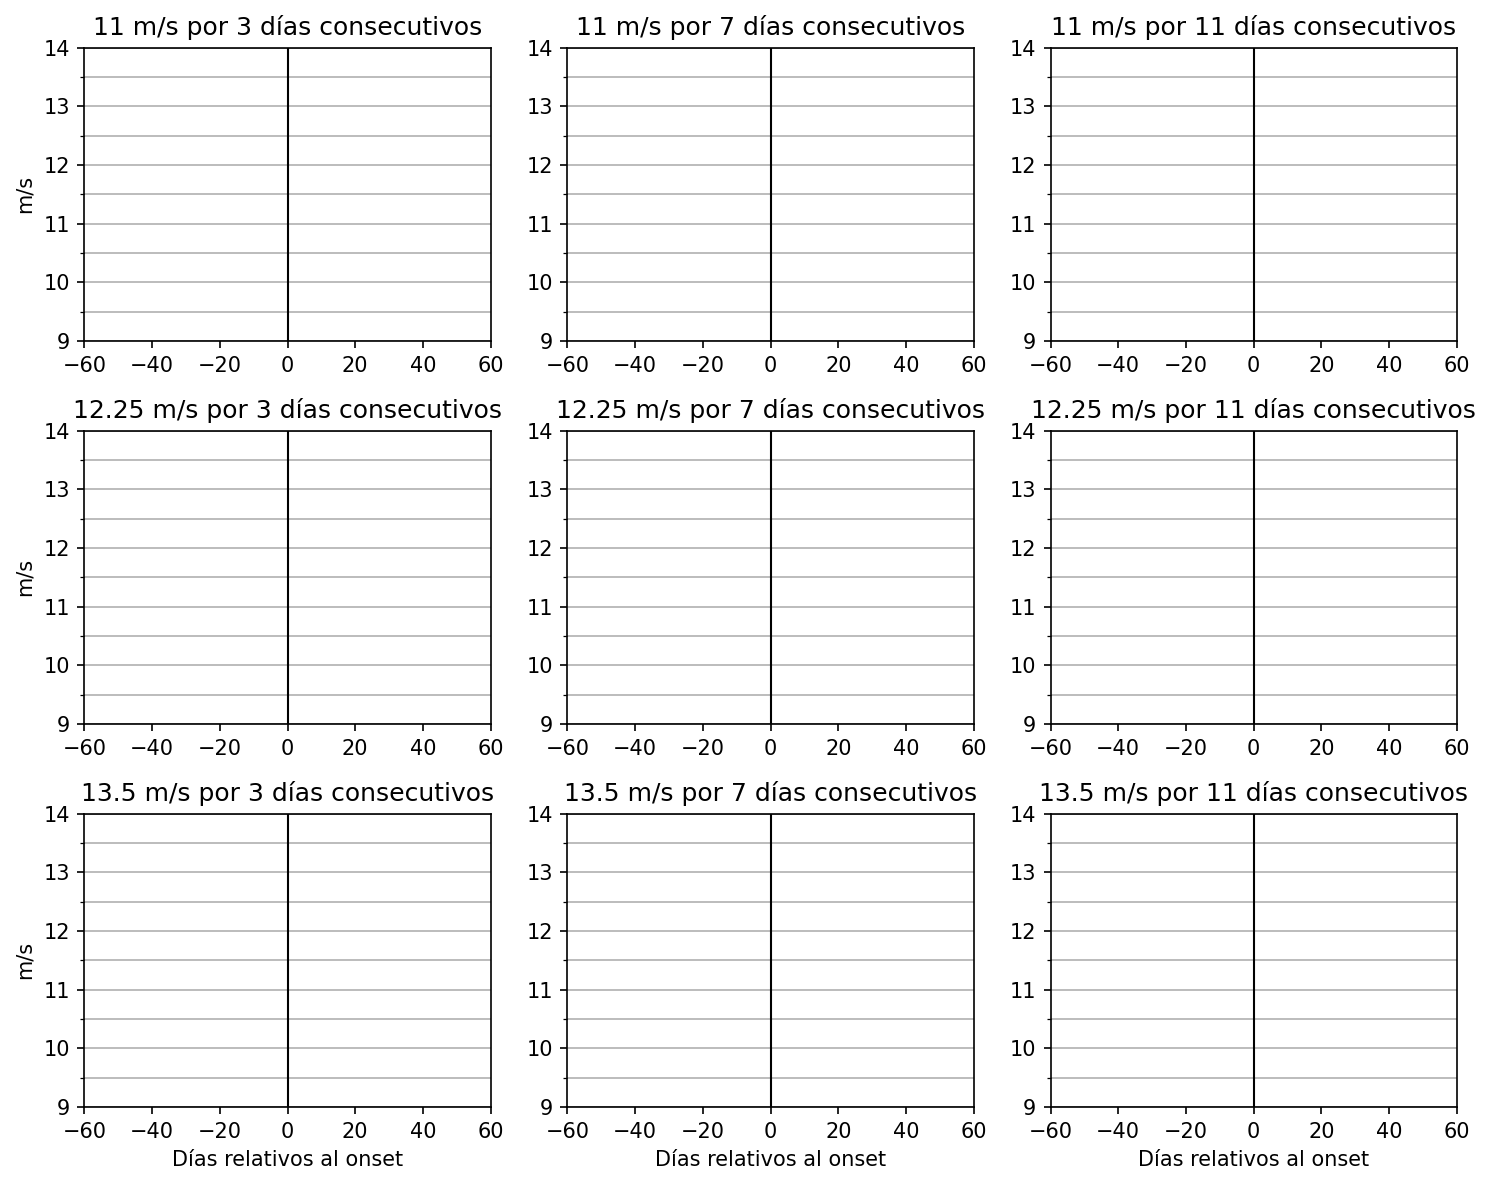

In [24]:
df_mean = df.copy()

# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = [11, 12.25, 13.5]
dias = [3, 7, 11]

# Mes inicial.
m_i = 4

lim = [ (9, 14), 0.6]
step = [0.5, 0.05]
title = "onset_criteria_u.png"
fig_s = [None] #* 2
axes_s = [None] #* 2

for i in range( len(fig_s) ):
    # Ajustes de gráficas múltiples.
    fig_s[i], axes_s[i] = plt.subplots(len(umbral), len(dias))
    fig_s[i].set_facecolor("w")
    fig_s[i].set_size_inches(10, 8)
    fig_s[i].set_dpi(150)

for i_n, n in enumerate(dias):
    for i_u, u in enumerate(umbral):
        df_mean_ind = pd.DataFrame(
            df_mean.copy(), columns = ["Cuenca"] )

        c = "Cuenca"

        # Nombre de las columnas dummy.
        proc = [c]
        for i in range(0, n):
            proc.append(c +
                "_" + str(i)) 

        # Traslapa los últimos n días 
        # y da un valor de 1 a cada día 
        # que cumpla con el umbral.
        for i, p in enumerate(proc[1:]):
            df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
            df_mean_ind[p].clip( upper = u,
                inplace = True )
            df_mean_ind[p] = df_mean_ind[p].where(
                df_mean_ind[p] == u, 0)
            df_mean_ind[p] = df_mean_ind[p].where(
                df_mean_ind[p] < u, 1)

        # El índice es uno si los n
        # cumplen con el umbral.
        ind = "Index_" + c
        df_mean_ind[ind] = 0
        for i in range(n):
            df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
        df_mean_ind[ind] = df_mean_ind[ ind
            ].where(df_mean_ind[ind] == n, 0)
        df_mean_ind[ind] = df_mean_ind[ ind
            ].where(df_mean_ind[ind] < n, 1)
        df_mean_ind.drop(proc[1:],
            axis = 1, inplace = True)

        # Crea una tabla con los valores anuales.
        col = []
        name = "Cuenca"
        col.append(name + " - Onset")
        col.append(name + " - Withdrawal")
        col.append(name + " - Length")

        date = pd.DataFrame()
        years = range(1981, 2022)

        for j in years:
            # Solo utilizamos valores entre mayo y diciembre.
            df_year = df_mean_ind[ (df_mean_ind.index.year == j)
                & df_mean_ind.index.month.isin(range(m_i, 12)) ]

            row = []

            # Fechas.
            row.append( df_year.iloc[:, 1].idxmax() )
            row.append( df_year.iloc[::-1, 1].idxmax() )
            row.append( df_year.iloc[::-1, 1].idxmax()
                - df_year.iloc[:, 1].idxmax() )

            # Agregamos la fila al DataFrame.
            date = date.append([row])

        # Damos formato a las columnas y al índice.
        date.columns = col
        date.index = years
        date.index.name = "Año"
        # Recorremos al inicio de la racha de días de precipitación.
        date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(n, 'D')

        # Longitud de la temporada de lluvias.
        print(f"{u} mm/día, {n} días consecutivos, " +
            f"{date.iloc[:, 2].mean().days} días de duración")

        # Calculamos el shift necesario para alinear las fechas.
        shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)
        delta = shift.max()
        shift = shift.max() - shift

        for i in range( len(fig_s) ):

            # Creamos un DataFrame con año
            # como columnas y días como filas.
            pre_df = pd.DataFrame(
                df_mean.copy(), columns = [ df_mean.columns[i] ] )
            pre_df["Año"] = pre_df.index.year
            pre_df["Día"] = pre_df.index.dayofyear

            # Ajustamos el dayofyear de años bisiestos.
            qty = int( pre_df[ pre_df.index.is_leap_year ].shape[0] / 365 )
            pre_df.loc[ pre_df.index.is_leap_year, "Día"
                ] = list(range(1, 366)) * qty

            # Convertimos los años a columnas.
            pre_df = pre_df.pivot(index = "Día", columns = "Año")
            pre_df.columns = pre_df.columns.droplevel(0)

            # Alineamos las series de tiempo.
            for j in pre_df.columns:
                pre_df[j] = pre_df[j].shift(shift[j])

            # Promediamos y seleccionamos 120 días.
            pre_df = pre_df.mean(axis = 1)
            pre_df = pre_df.loc[delta - 60: delta + 60]
            pre_df.index = range(-60, 61)

            # Graficamos.
            axes_s[i][i_u, i_n].plot( (0, 0), ( lim[i][0], lim[i][1] ),
                color = "k", linewidth = 1 )
            pre_df.plot(ax = axes_s[i][i_u, i_n], color = "orange")

            axes_s[i][i_u, i_n].set_title(
                f"{u} m/s por {n} días consecutivos" )
            axes_s[i][i_u, i_n].set_xlim(-60, 60)
            axes_s[i][i_u, i_n].set_ylim(lim[i][0], lim[i][1])

            if i_n == 0: 
                axes_s[i][i_u, i_n].set_ylabel("m/s")
            if i_u == 2: 
                axes_s[i][i_u, i_n].set_xlabel("Días relativos al onset")

            for ax in axes_s[i].flatten():
                ax.set_yticks( np.arange(lim[i][0], lim[i][1], step[i]),
                    minor = True )
                ax.grid( visible = True, which = "both", axis ="y" )

            # Separación adecuada entre gráficas.
            fig_s[i].tight_layout()

            # Guardamos el archivo.
            fig_s[i].savefig( path_r + title )

rojo: precipitación
negro: viento


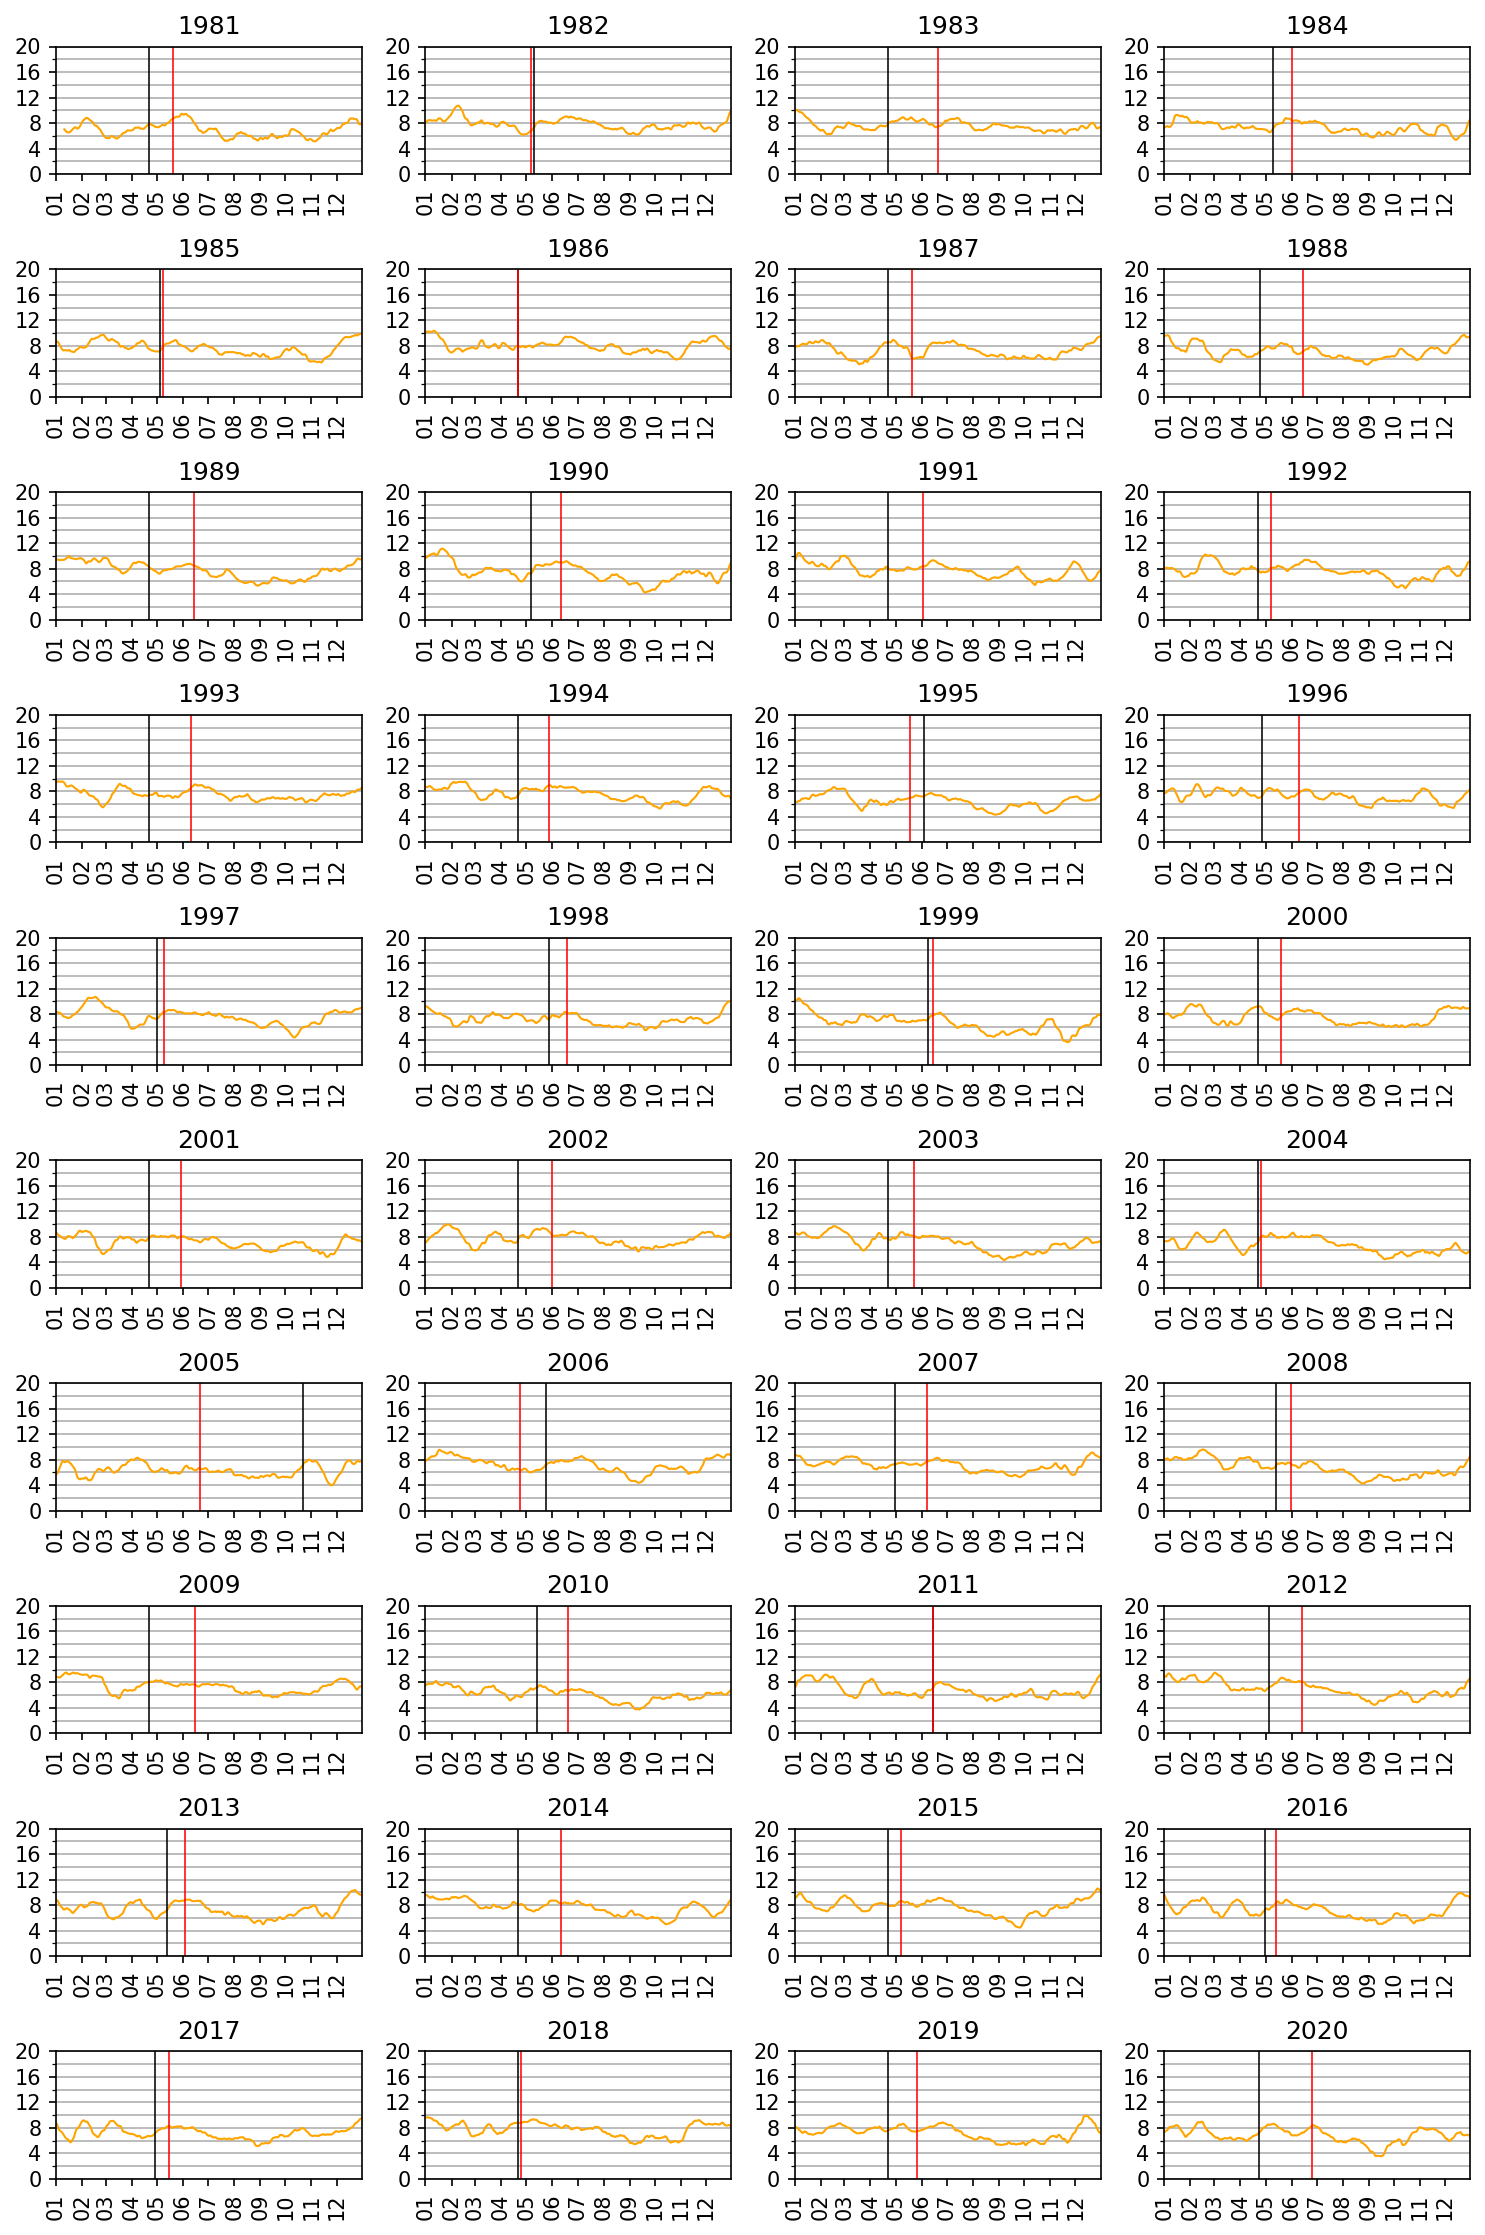

In [25]:
# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = 7.25
n = 10

# Mes inicial
m_i = 5

df_mean_ind = df.copy()

c = "Cuenca"

# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n):
    proc.append(c + "_" + str(i)) 

# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral,
        inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] == umbral, 0)
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] < umbral, 1)

# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = 0
for i in range(n):
    df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
df_mean_ind[ind] = df_mean_ind[ ind
    ].where(df_mean_ind[ind] == n, 0)
df_mean_ind[ind] = df_mean_ind[ ind
    ].where(df_mean_ind[ind] < n, 1)
df_mean_ind[ind] = df_mean_ind[ ind
    ].where( df_mean_ind.index.month.isin(
    range(m_i, 12) ), 0 )
df_mean_ind.drop(proc[1:],
    axis = 1, inplace = True)

# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
col.append(name + " - Length")

date = pd.DataFrame()
years = range(1981, 2021)

for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df_mean_ind[ (df_mean_ind.index.year == j)
        & df_mean_ind.index.month.isin(range(m_i, 12)) ]

    row = []

    # Fechas.
    row.append( df_year.iloc[:, 1].idxmax() )
    row.append( df_year.iloc[::-1, 1].idxmax() )
    row.append( df_year.iloc[::-1, 1].idxmax()
        - df_year.iloc[:, 1].idxmax() )

    # Agregamos la fila al DataFrame.
    date = date.append([row])

# Damos formato a las columnas y al índice.
date.columns = col
date.index = years
date.index.name = "Año"
# Recorremos al inicio de la racha de días de precipitación.
date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(n, 'D')

# Calculamos el shift necesario para alinear las fechas.
shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)

# Guarda las series de tiempo.
#date.to_csv(path_d + "onset_CHIRPS.csv")
#shift.to_csv(path_d + "shift_CHIRPS.csv")

year = np.arange( 1981, 2021 )

#print(f"Onset     : {onset.day:02d}"
#    + f" {onset.month_name()}")
#print(f"Withdrawal: {withdrawal.day:02d}"
#    + f" {withdrawal.month_name()}")

# Graficamos.
fig, axes = plt.subplots(10, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150)

xtick_lab = [ f"{x:02d}" for x in range(1, 13) ]


for i in range( len(year) ):
    df_year = df_mean_ind[ df_mean_ind.index.year == year[i] ]

    # Fechas.
    onset = date.iloc[date.index == year[i], 0]
    #withdrawal = date.iloc[date.index == year[i], 1]

    onset_pre = date_pre.iloc[date_pre.index == year[i], 0]

    axes[i].plot( df_year.iloc[:, 0], linewidth = 1, color = "orange" )
    #ax.plot(df_year.iloc[:, 1])

    # Onset y withdrawal.
    axes[i].plot( (onset, onset), (0, 20),
        color = "k", linewidth = 0.75 )
    #axes[i].plot( (withdrawal, withdrawal), (0, 20), 
    #    color = "k", linewidth = 0.75 ) 

    axes[i].plot( (onset_pre, onset_pre), (0, 20),
        color = "r", linewidth = 0.75 )

    axes[i].set_title(year[i])
    axes[i].set_yticks( range(0, 24, 4), minor = False )
    axes[i].set_yticks( range(0, 24, 2), minor = True)
    axes[i].grid(axis = "y", which = "both")
    #axes[0].set_ylabel("Precipitación diaria [mm]")
    #axes[0].set_xlabel("Tiempo")
    axes[i].set_ylim(0, 20)
    #axes[i].set_ylim(0, np.ceil(df_year.iloc[:, 0].max()) )
    axes[i].set_xlim( pd.to_datetime( str(year[i]) + "-01-01" ),
        pd.to_datetime( str(year[i]) + "-12-31") )
    # Formato de fecha.
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    axes[i].set_xticks( axes[i].get_xticks(), xtick_lab, rotation = 90 )

# Separación adecuada entre gráficas.
fig.tight_layout()
fig.savefig( path_r + "u_pre_ind_anual.png", bbox_inches = "tight" )

print("rojo: precipitación")
print("negro: viento")

Wind onset: 06 May


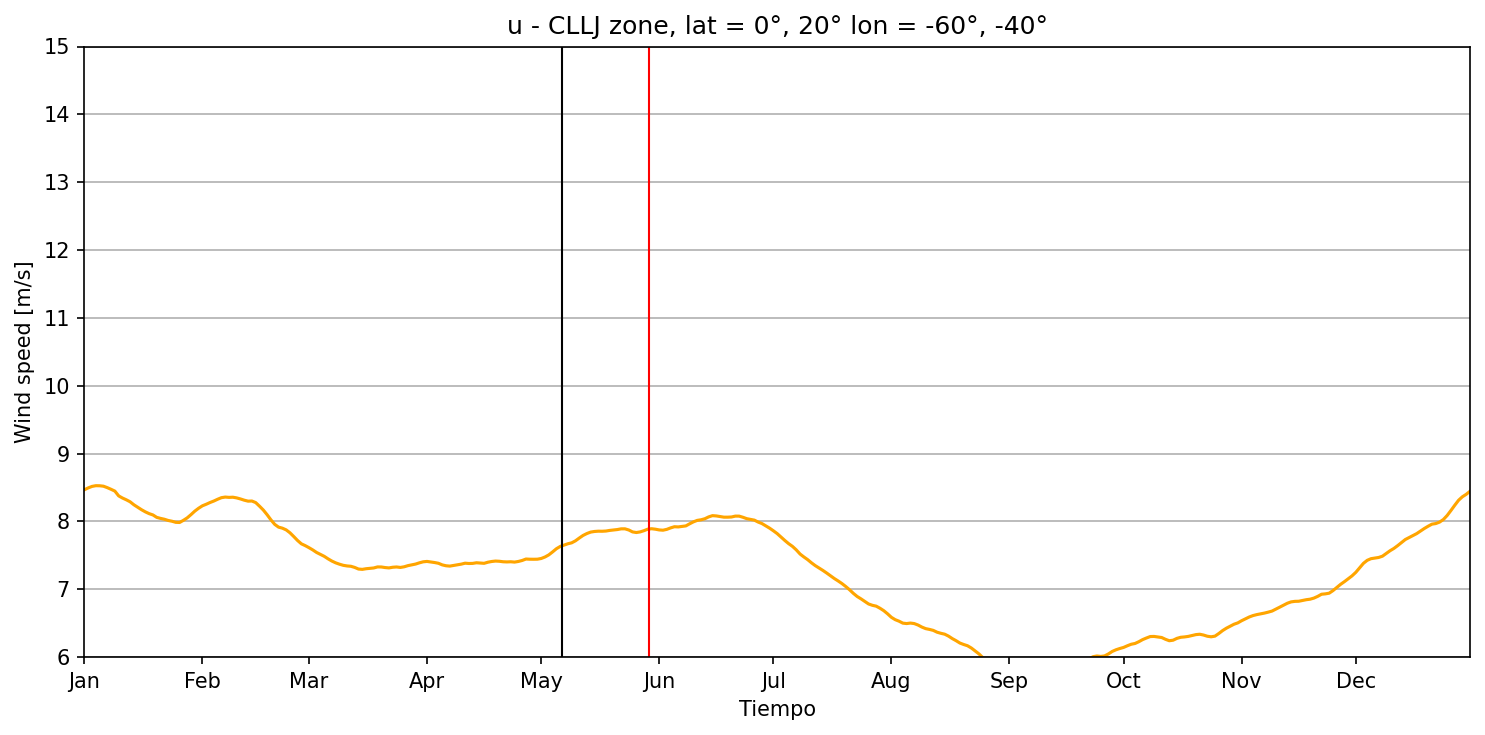

In [26]:
# Cargamos la fecha media de onset. 

date_1 = date.copy()
date_pre_1 = date_pre.copy()

# Promediamos las fechas
for i in [date_1, date_pre_1]:
    # Convertimos a día juliano.
    i.iloc[:, 0] = i.iloc[:, 0].apply(lambda x: x.dayofyear)
    i.iloc[:, 1] = i.iloc[:, 1].apply(lambda x: x.dayofyear)
    # Ajustamos los años bisiestos.
    i.iloc[i.index % 4 == 0, 0:2] = i.iloc[ i.index % 4 == 0, 0:2 ] - 1
    # Reconvertimos a fecha.
    i.iloc[:, 0] = ( pd.to_datetime("1995-01-01")
        + pd.to_timedelta(i.iloc[:, 0], "D") )
    i.iloc[:, 1] = ( pd.to_datetime("1995-01-01")
        + pd.to_timedelta(i.iloc[:, 1], "D") )

onset = date_1.iloc[:, 0].mean()
onset_pre = date_pre_1.iloc[:, 0].mean()

pre_xr = clip.copy()

# Seleccionamos los años bisiestos.
leap_xr = pre_xr.sel(time = pre_xr.time.dt.is_leap_year)
# Cantidad de años bisiestos.
years_leap = leap_xr.time.shape[0] / 365
# Ponderación para promedio.
leap_xr *= years_leap
# Promedio por día juliano.
leap_xr = leap_xr.groupby("time.dayofyear").mean()
# Corregimos los días de 1 a 365.
leap_xr["dayofyear"] = np.arange(1, 366)
# Dimensión para concatenar.
leap_xr = leap_xr.expand_dims("concat")

# Seleccionamos los años no bisiestos.
not_leap_xr = pre_xr.sel(time = ~pre_xr.time.dt.is_leap_year)
# Cantidad de años bisiestos.
years_not_leap = not_leap_xr.time.shape[0] / 365  
# Ponderación para promedio.
not_leap_xr *= years_not_leap
# Promedio por día juliano.
not_leap_xr = not_leap_xr.groupby("time.dayofyear").mean()
# Dimensión para concatenar.
not_leap_xr = not_leap_xr.expand_dims("concat")

# Promedio ponderado de años bisiestos y no bisiestos.
pre_xr_mean = xr.concat( (not_leap_xr, leap_xr), "concat"
    ).mean("concat") * 2 / (years_leap + years_not_leap)

# Convertimos a DataFrame.
df_mean_2 = pre_xr_mean.mean( ["longitude", "latitude"]).to_dataframe()
df_mean_2.columns = ["Cuenca"]

df_mean_2["Cuenca"] = - df_mean_2["Cuenca"]

# Cambiamos de dayofyear a fecha.
df_mean_2.index = pd.date_range( "1995-01-01", "1995-12-31", freq = "1D" )

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 5)
fig.set_dpi(150)

ax.plot( df_mean_2, color = "orange" )
ax.grid(axis = "y")
ax.set_title("u - CLLJ zone, lat = " + str(zones[1]) + "°, " + str(zones[3])
    + "° lon = " + str(zones[0]) + "°, " + str(zones[2]) + "°" )
ax.set_ylabel("Wind speed [m/s]")
ax.set_xlabel("Tiempo")
ax.set_ylim(6, 15)
ax.set_xlim( pd.to_datetime("1995-01-01"), pd.to_datetime("1995-12-31") )
# Formato de fecha.
ax.xaxis.set_major_locator( mdates.MonthLocator() )
ax.xaxis.set_major_formatter( mdates.DateFormatter("%b") )

# Onset.
ax.plot( (onset, onset), (6, 15), color = "k", linewidth = 1 )
ax.plot( (onset_pre, onset_pre), (6, 15), color = "r", linewidth = 1 )
print(f"Wind onset: {onset.day:02d}" + f" {onset.month_name()}")

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig( path_r + "u_mean_CLLJ.png", bbox_inches = "tight" )

rojo: precipitación
negro: viento


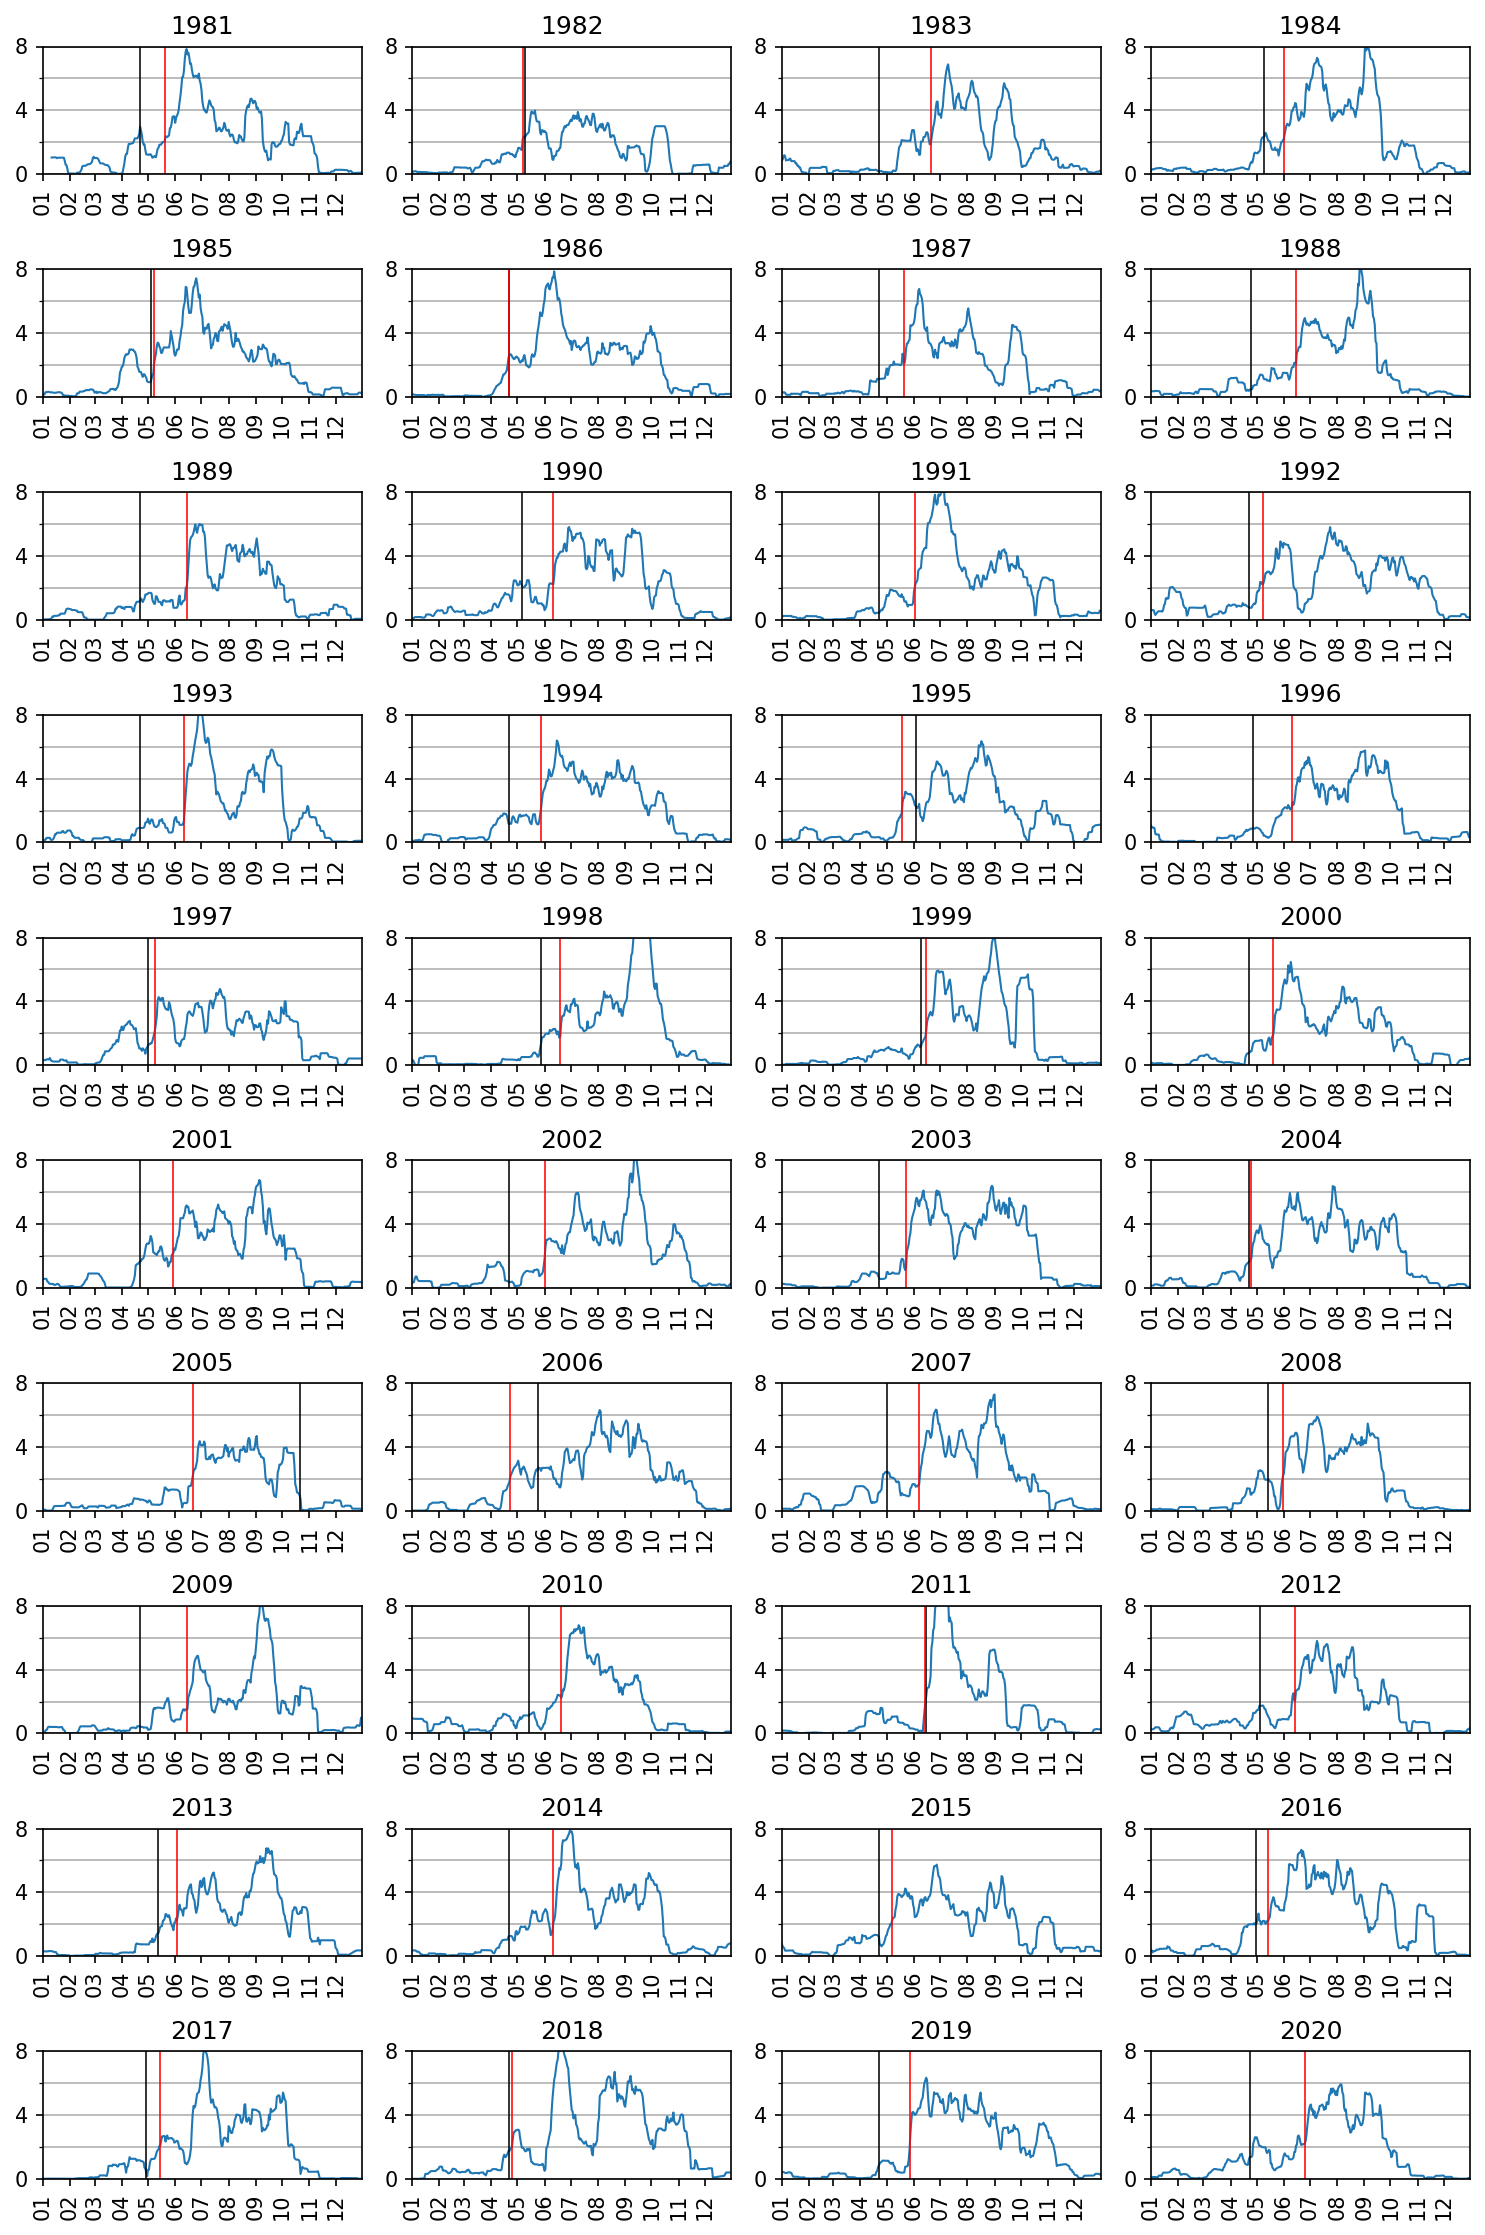

In [27]:
# Precipitación anual.
df_pre = pd.read_csv(path_d + "pre_daily_CHIRPS.csv", index_col = "time" )
df_pre.index = pd.to_datetime( df_pre.index )
df_mean_ind_2 = pd.DataFrame(df_pre.copy(), columns = ["Cuenca"] )

# Graficamos.
fig, axes = plt.subplots(10, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150)

xtick_lab = [ f"{x:02d}" for x in range(1, 13) ]


for i in range( len(year) ):
    df_year_2 = df_mean_ind_2[ df_mean_ind_2.index.year == year[i] ]

    # Fechas.
    onset = date.iloc[date.index == year[i], 0]
    withdrawal = date.iloc[date.index == year[i], 1]

    onset_pre = date_pre.iloc[date_pre.index == year[i], 0]

    axes[i].plot(df_year_2.iloc[:, 0], linewidth = 1)
    #ax.plot(df_year_2.iloc[:, 1])

    # Onset y withdrawal.
    axes[i].plot( (onset, onset), (0, 12),
        color = "k", linewidth = 0.75 )
    #axes[i].plot( (withdrawal, withdrawal), (0, 12), 
    #    color = "k", linewidth = 0.75 ) 

    axes[i].plot( (onset_pre, onset_pre), (0, 12),
        color = "r", linewidth = 0.75 )

    axes[i].set_title(year[i])
    axes[i].set_yticks( range(0, 14, 4), minor = False )
    axes[i].set_yticks( range(0, 14, 2), minor = True)
    axes[i].grid(axis = "y", which = "both")
    #axes[0].set_ylabel("Precipitación diaria [mm]")
    #axes[0].set_xlabel("Tiempo")
    axes[i].set_ylim(0, 8)
    #axes[i].set_ylim(0, np.ceil(df_year_2.iloc[:, 0].max()) )
    axes[i].set_xlim( pd.to_datetime( str(year[i]) + "-01-01" ),
        pd.to_datetime( str(year[i]) + "-12-31") )
    # Formato de fecha.
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    axes[i].set_xticks( axes[i].get_xticks(), xtick_lab, rotation = 90 )

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig( path_r + "pre_u_ind_anual.png", bbox_inches = "tight" )

print("rojo: precipitación")
print("negro: viento")

Onset correlation            : 0.252
Onset 20 year av. correlation: 0.660


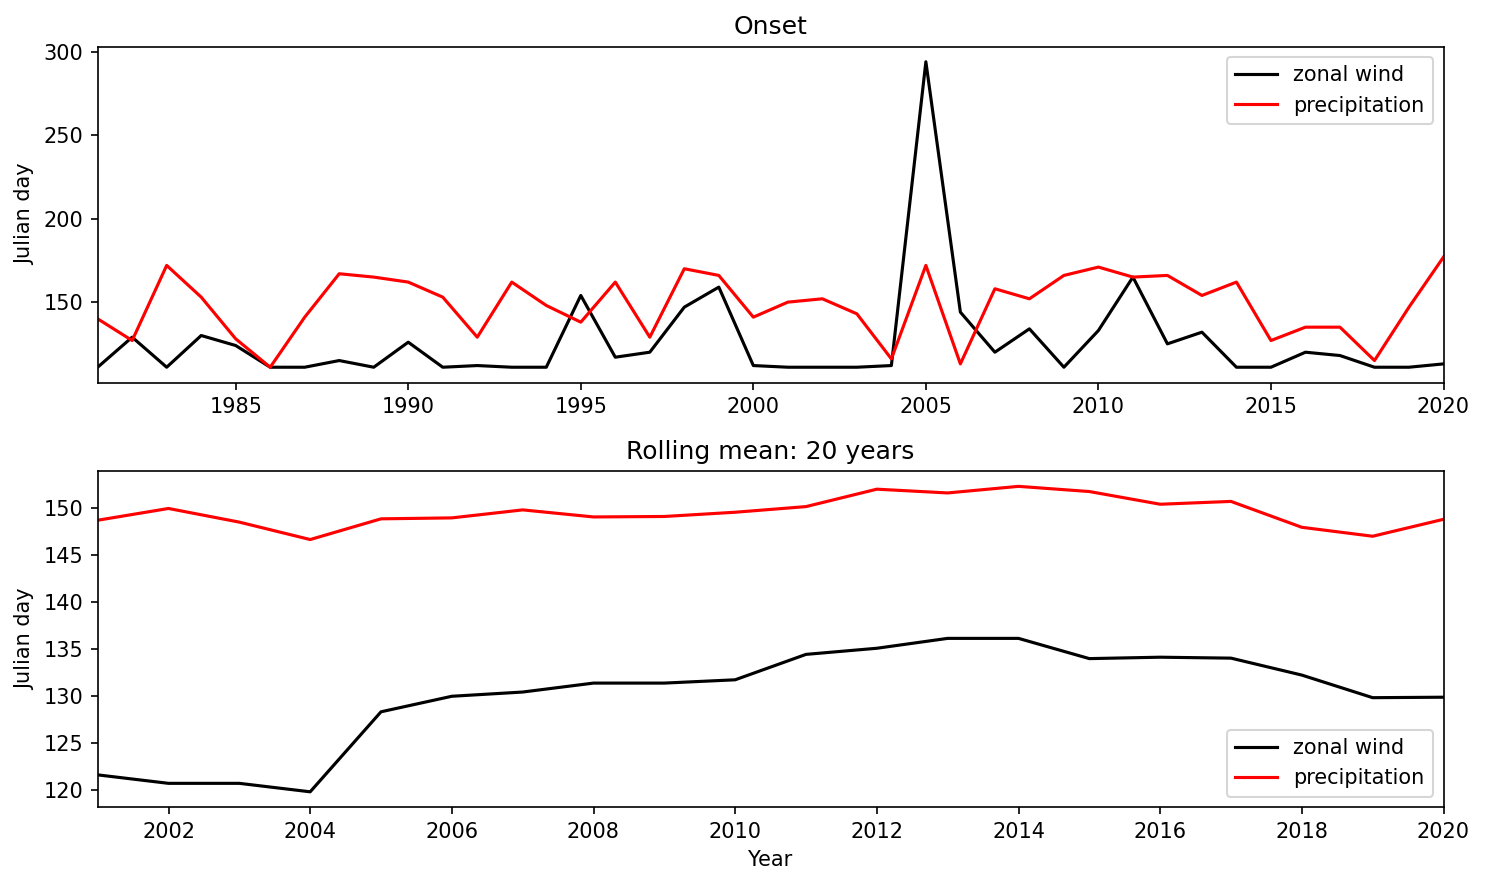

In [28]:
# Correlación entre índice de precipitación y de viento.

c_date = date.copy()
c_date_pre = date_pre.copy()

# Se convierten las fechas a días julianos.
c_date["Cuenca - Onset"] = c_date["Cuenca - Onset"].apply(
    lambda x: pd.to_datetime(x))
c_date["Cuenca - Onset"] = c_date["Cuenca - Onset"].apply(
    lambda x: x.dayofyear)
c_date["Cuenca - Withdrawal"] = c_date["Cuenca - Withdrawal"].apply(
    lambda x: pd.to_datetime(x))
c_date["Cuenca - Withdrawal"] = c_date["Cuenca - Withdrawal"].apply(
    lambda x: x.dayofyear)

# Se convierten las fechas a días julianos.
c_date_pre["Cuenca - Onset"] = c_date_pre["Cuenca - Onset"].apply(
    lambda x: pd.to_datetime(x))
c_date_pre["Cuenca - Onset"] = c_date_pre["Cuenca - Onset"].apply(
    lambda x: x.dayofyear)
c_date_pre["Cuenca - Withdrawal"] = c_date_pre["Cuenca - Withdrawal"].apply(
    lambda x: pd.to_datetime(x))
c_date_pre["Cuenca - Withdrawal"] = c_date_pre["Cuenca - Withdrawal"].apply(
    lambda x: x.dayofyear)

# Media móvil.
l = 20
c_date_pre["Onset - Mean"] = c_date_pre["Cuenca - Onset"
    ].rolling(window = l).mean()
c_date_pre["Withdrawal - Mean"] = c_date_pre["Cuenca - Withdrawal"
    ].rolling(window = l).mean()
c_date["Onset - Mean"] = c_date["Cuenca - Onset"
    ].rolling(window = l).mean()
c_date["Withdrawal - Mean"] = c_date["Cuenca - Withdrawal"
    ].rolling(window = l).mean()

# Graficamos.
#fig, axes = plt.subplots(4)
fig, axes = plt.subplots(2)
fig.set_facecolor("w")
#fig.set_size_inches(10, 12)
fig.set_size_inches(10, 6)
fig.set_dpi(150)

c_date["Cuenca - Onset"].plot(ax = axes[0], color = "k")
c_date_pre["Cuenca - Onset"].plot(ax = axes[0], color = "r")
c_date["Onset - Mean"].plot(ax = axes[1], color = "k")
c_date_pre["Onset - Mean"].plot(ax = axes[1], color = "r")

#date["Cuenca - Withdrawal"].plot(ax = axes[2])
#date_pre["Cuenca - Withdrawal"].plot(ax = axes[2])
#date["Withdrawal - Mean"].plot(ax = axes[3])
#date_pre["Withdrawal - Mean"].plot(ax = axes[3])

# Formato de ejes.
for ax in axes:
    ax.set_ylabel("Julian day")
    ax.legend( ["zonal wind", "precipitation"] )
    ax.set_xlabel("")
for ax in axes[0::2]:
    ax.set_xlim(1981, 2020)
for ax in axes[1::2]:
    ax.set_xlim(1981 + l, 2020)
    # El eje tiene puras marcas enteras.
    ax.xaxis.set_major_locator( ticker.MaxNLocator(integer = True) )
ax.set_xlabel("Year")

axes[0].set_title("Onset")
axes[1].set_title(f"Rolling mean: {l} years")
#axes[2].set_title("Withdrawal")
#axes[3].set_title(f"Rolling mean: {l} years")

# Correlaciones de las series.
corr = []
corr.append( c_date["Cuenca - Onset"].corr(
    c_date_pre["Cuenca - Onset"] ) )
corr.append( c_date["Onset - Mean"].corr(
    c_date_pre["Onset - Mean"] ) )
#corr.append( date["Cuenca - Withdrawal"].corr(
#    date_pre["Cuenca - Withdrawal"] ) )
print(f"Onset correlation            : {corr[0]:.3f}")
print(f"Onset 20 year av. correlation: {corr[1]:.3f}")
#print(f"Withdrawal correlation: {corr[1]:.3f}")

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig(path_r + "comparacion_viento_pre.png")